In [1]:
import bt
import sys
import glob
import pickle
import numpy as np
import pandas as pd
import scipy.signal as signal
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
# concatenate & preprocessing data
dfList = []
for file in glob.glob(sys.path[0] + '/dataset/*.csv'):
    tmp = pd.read_csv(file, index_col=0)[['Value_Close']]
    tmp.rename(columns={'Value_Close': file.split('-')[0].split('/')[-1]}, inplace=True)
    tmp.index = pd.to_datetime(tmp.index)
    dfList.append(tmp)
df = pd.concat(dfList, axis=1)
df = df.resample('1D').last()
df.fillna(method='ffill', inplace=True)

### augmented Engle-Granger two-step cointegration test
[statsmodels.tsa.stattools.coint](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html)

In [3]:
stat, p, cp = coint(df[['FXF1']], df[['EXF1']])
print('p-value: %.5f\n' % p)
print('critical values \n%.5f at 1percent\n%.5f at 5percent\n%.5f at 10percent' 
      % (cp[0], cp[1], cp[2])
)

p-value: 0.02378

critical values 
-3.89795 at 1percent
-3.33697 at 5percent
-3.04504 at 10percent


### Augmented Dicky Fuller's Test

FXF1 adf p-value: 0.05286



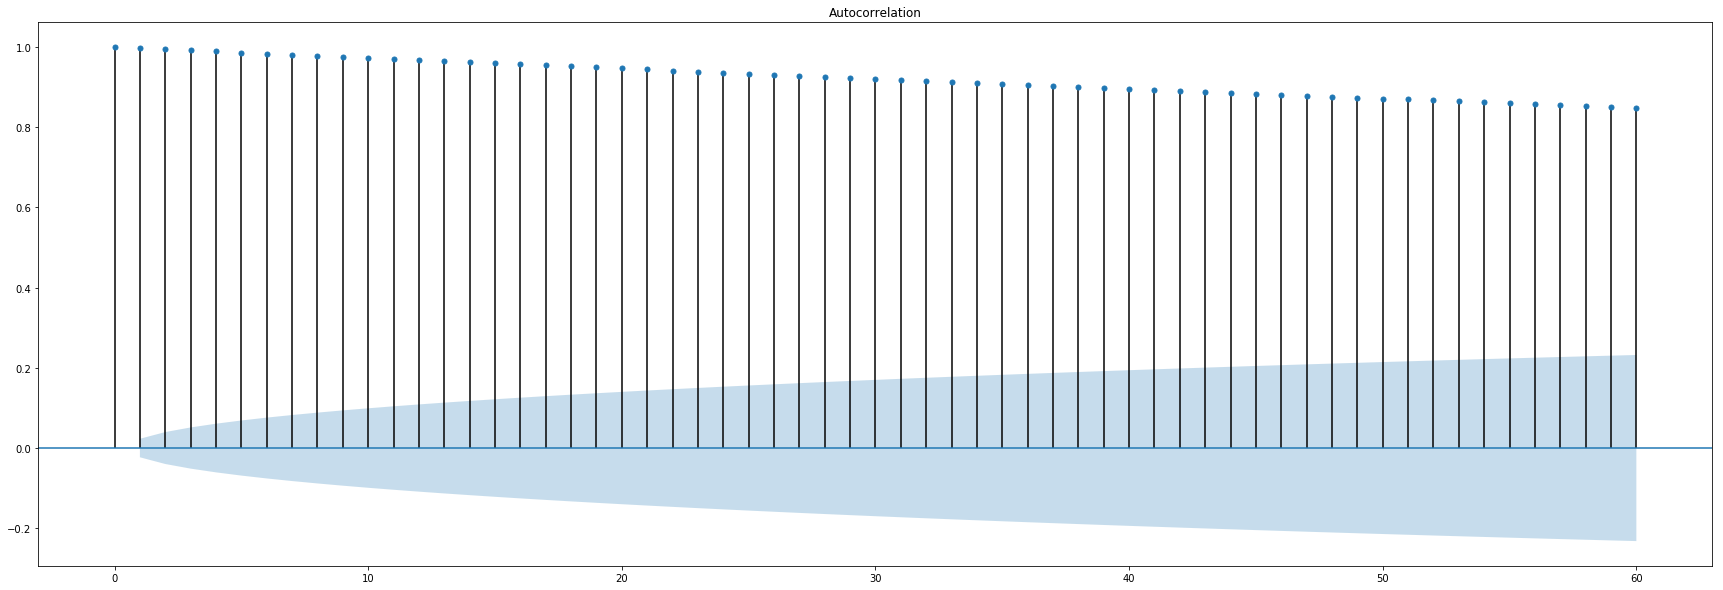

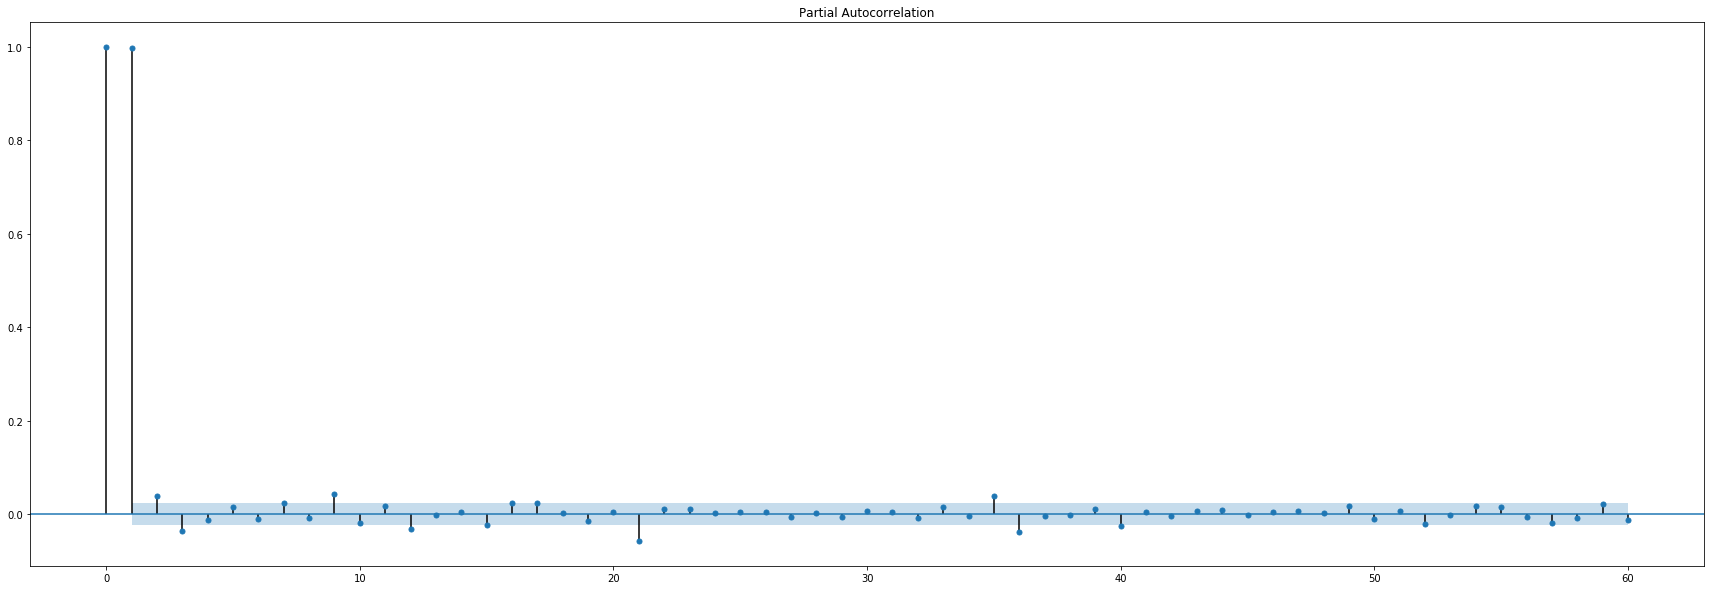

In [4]:
_, p, _, _, _, _ = adfuller(df['FXF1'])
print('FXF1 adf p-value: %.5f\n' % p)

fig, ax = plt.subplots(figsize=(30, 10))
plot_acf(df['FXF1'], lags=60, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(30, 10))
plot_pacf(df['FXF1'], lags=60, ax=ax)
plt.show()

EXF1 adf p-value: 0.22633



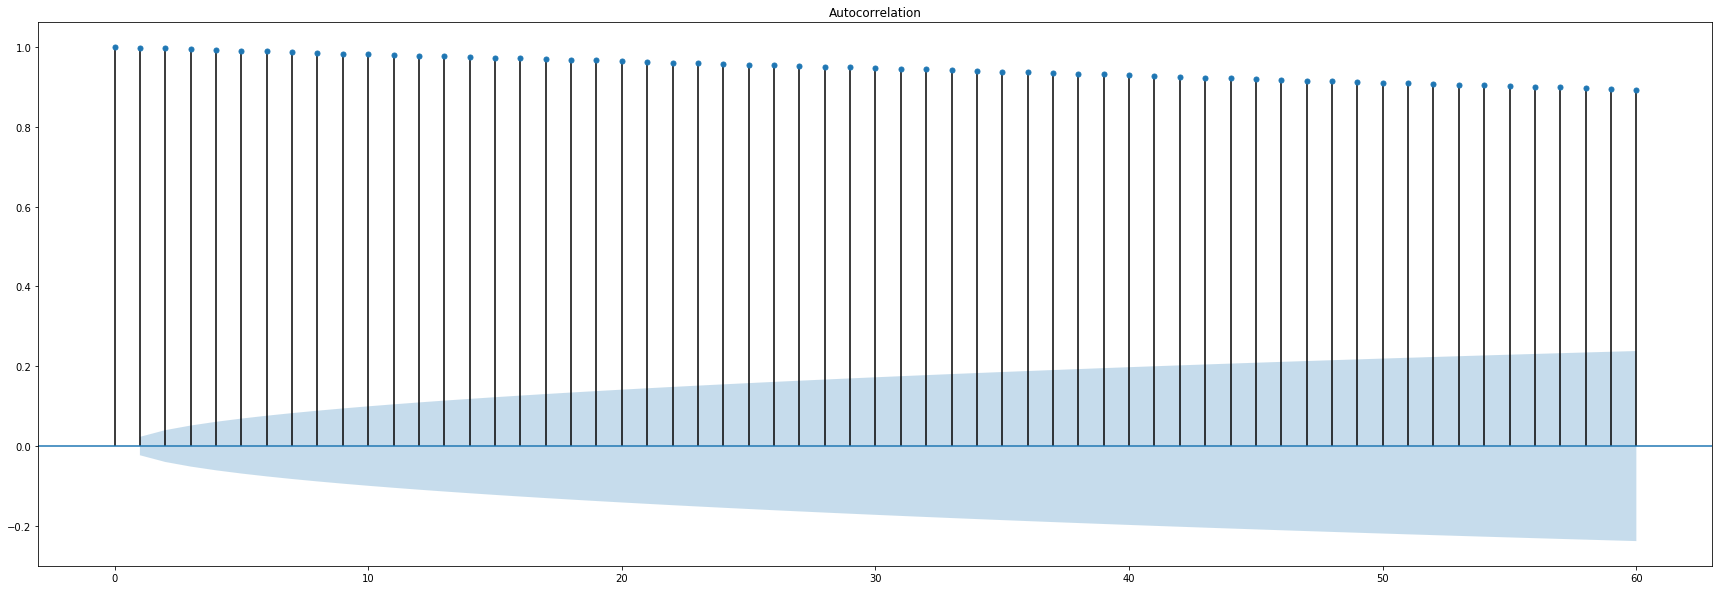

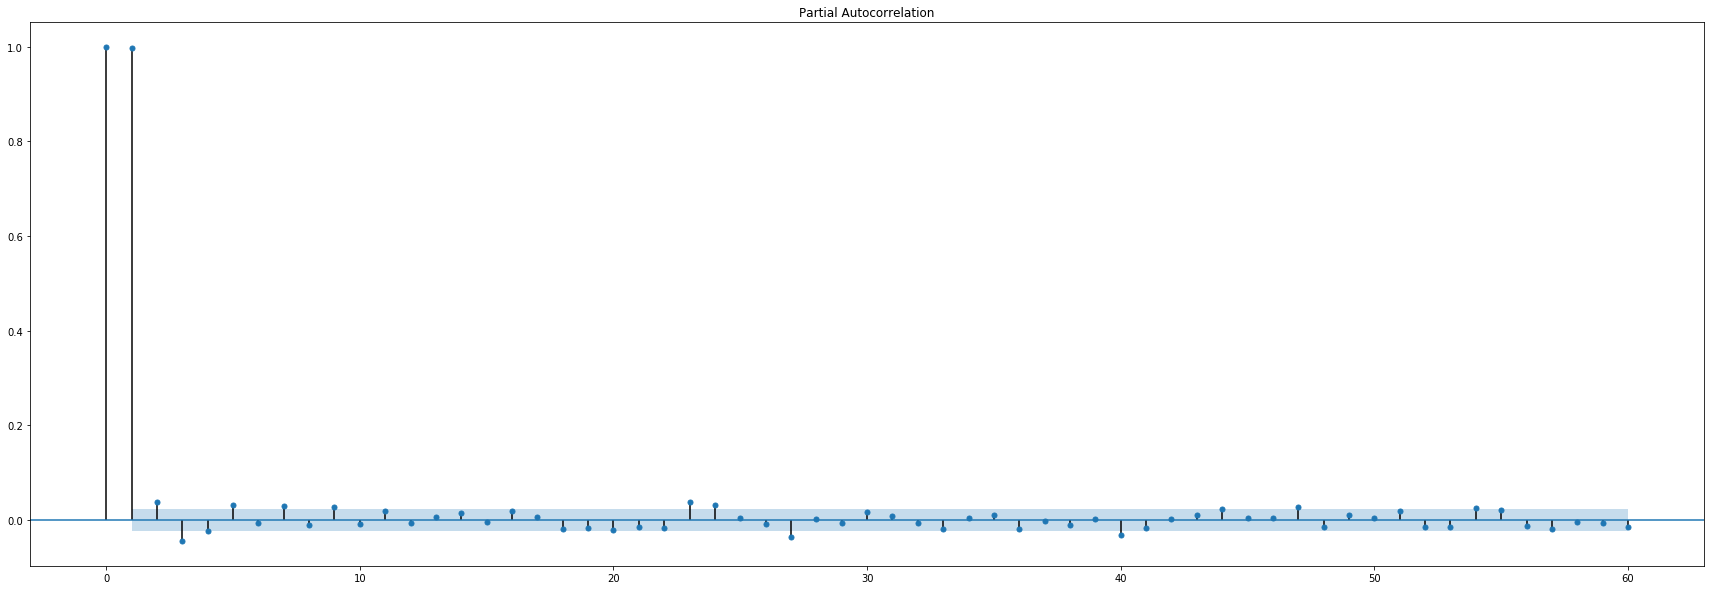

In [5]:
_, p, _, _, _, _ = adfuller(df['EXF1'])
print('EXF1 adf p-value: %.5f\n' % p)

fig, ax = plt.subplots(figsize=(30, 10))
plot_acf(df['EXF1'], lags=60, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(30, 10))
plot_pacf(df['EXF1'], lags=60, ax=ax)
plt.show()

### Cross Correlation Plot

In [6]:
def ccf(x, y):
    if isinstance(x, (pd.Series, pd.DataFrame)):
        x = x.values
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y = y.values
        
    nom = signal.correlate(x-np.mean(x), y-np.mean(y), method='direct')
    denom = np.std(x)*np.std(y)*len(x)
    return nom/denom

def plot_ccf(x, y, maxlags=20):
    result = ccf(x, y)
    lo = (len(result)-1)//2-maxlags #just get +/- 10 elements around lag 0
    hi = (len(result)-1)//2+(maxlags+1)

    #Make a plot like ccf
    f, ax = plt.subplots(figsize=(30, 10))
    ax.stem(np.arange(-1*maxlags,maxlags+1), result[lo:hi], linefmt='b-', markerfmt='go', basefmt='b-')
    ax.set_xticks(np.arange(-1*maxlags,maxlags+1))
    plt.title('CCF - ' + x.name + ' vs. ' + y.name)
    plt.show()

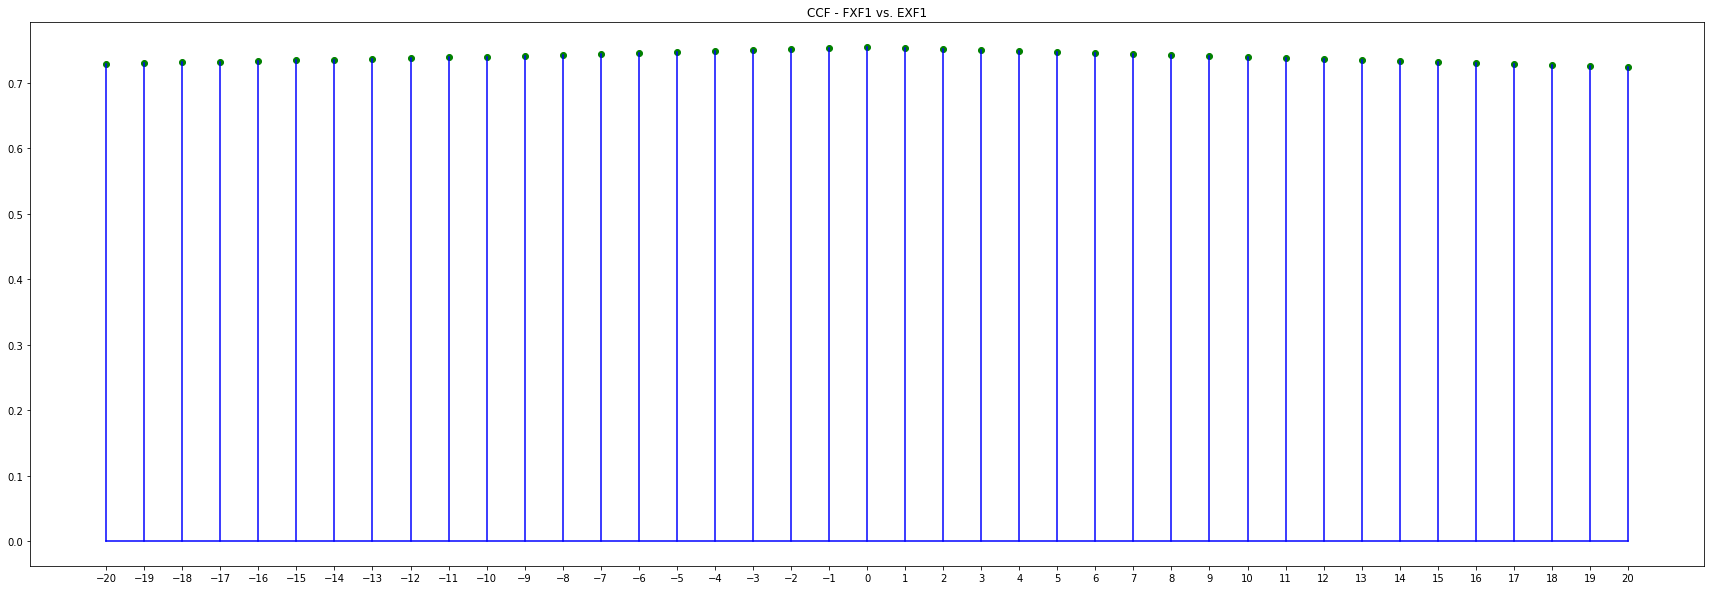

In [7]:
fx, _ = boxcox(df['FXF1'])
ex, _ = boxcox(df['EXF1'])
fx = pd.Series(fx, index=df.index, name='FXF1')
ex = pd.Series(ex, index=df.index, name='EXF1')
plot_ccf(fx, ex)

## Listing all Result of ExF strategy

In [8]:
with open(sys.path[0] + '/result/ExF-2019-05-24 11:33:40.619394.pkl', 'rb') as f:
    ExF = pickle.load(f)

In [9]:
# Backtest Statistics Table
'''
CAGR: compound annual growth rate
'''
ExF.display()

Stat                 ExF
-------------------  ----------
Start                1999-07-20
End                  2019-05-14
Risk-free rate       0.00%

Total Return         5457.08%
Daily Sharpe         0.53
Daily Sortino        0.85
CAGR                 22.48%
Max Drawdown         -73.99%
Calmar Ratio         0.30

MTD                  -1.00%
3m                   2.90%
6m                   -23.01%
YTD                  -13.42%
1Y                   -30.65%
3Y (ann.)            4.04%
5Y (ann.)            -7.03%
10Y (ann.)           0.96%
Since Incep. (ann.)  22.48%

Daily Sharpe         0.53
Daily Sortino        0.85
Daily Mean (ann.)    26.59%
Daily Vol (ann.)     50.19%
Daily Skew           0.21
Daily Kurt           9.76
Best Day             30.75%
Worst Day            -29.67%

Monthly Sharpe       0.62
Monthly Sortino      1.37
Monthly Mean (ann.)  37.13%
Monthly Vol (ann.)   59.50%
Monthly Skew         0.78
Monthly Kurt         2.32
Best Month           63.26%
Worst Month          -56.7

(10032.01, 18789.99)

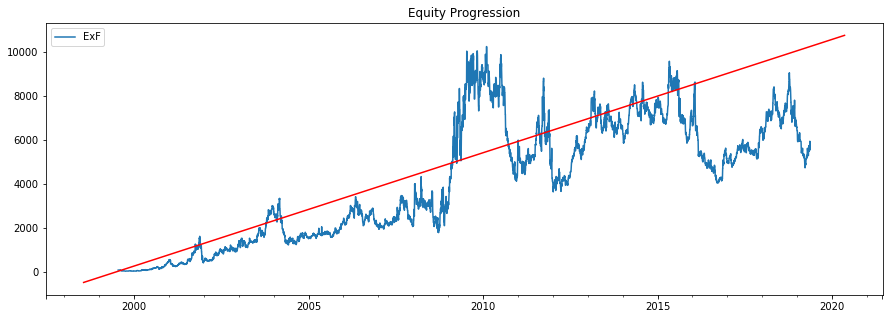

In [10]:
# Equity Plot
ExF.plot()
plt.plot(plt.xlim(), plt.ylim(), 'k-', color = 'r')
plt.ylim(plt.ylim())
plt.xlim(plt.xlim())

In [11]:
# return in each month
list(ExF.values())[0].return_table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
1999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.414839,-0.144794,0.032318,0.112616,0.030347,-0.407772
2000,0.177186,-0.115482,0.447480,0.262771,-0.096141,0.235200,0.610681,0.205585,-0.284745,0.227205,0.580840,0.632588,8.347089
2001,-0.360630,-0.173785,0.040370,0.330915,0.011759,-0.081975,0.604145,0.453150,0.035392,0.169313,0.121320,-0.567816,-0.070813
2002,0.072279,-0.078584,0.094628,0.392114,0.108924,0.124175,0.012308,0.083192,-0.114280,0.108312,-0.039316,0.300509,1.524125
2003,0.184778,-0.095315,-0.171214,0.236465,-0.044886,0.070390,0.370112,-0.133891,-0.032046,0.505483,0.070700,0.072537,1.229948
2004,-0.195698,0.298299,-0.332825,-0.287569,-0.111209,0.140210,-0.109700,0.053546,0.108514,0.158633,-0.018257,-0.115988,-0.474111
2005,0.073348,0.056616,-0.042815,0.035421,0.000692,0.022881,0.003688,-0.082520,0.104303,0.000385,0.148389,0.130487,0.519504
2006,-0.047803,0.154005,0.117372,0.046633,-0.037789,-0.051833,-0.219416,0.175693,0.044589,0.087453,-0.206515,-0.094533,-0.121863
2007,0.016773,-0.047035,0.156570,-0.017274,0.038481,-0.003365,0.026719,0.319243,-0.098093,0.025081,-0.168497,-0.111513,0.054512
2008,0.550646,-0.105507,0.155262,-0.074522,-0.043214,-0.105250,-0.172728,0.007381,-0.068503,0.304627,0.011916,0.132190,0.473078


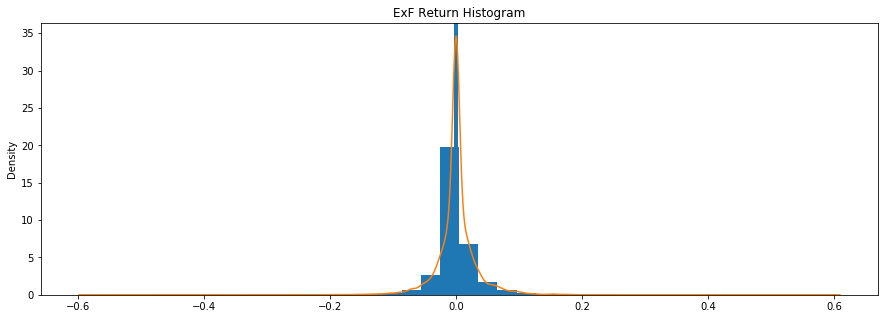

In [12]:
# return histogram
ExF.plot_histogram()

Text(0.5,1,'Weights Plot (excluding total weights)')

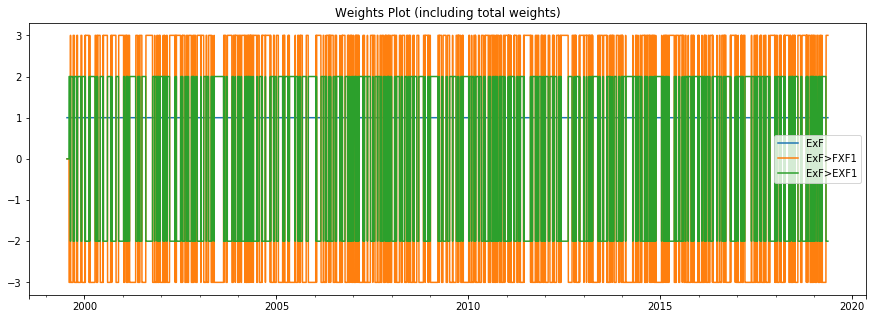

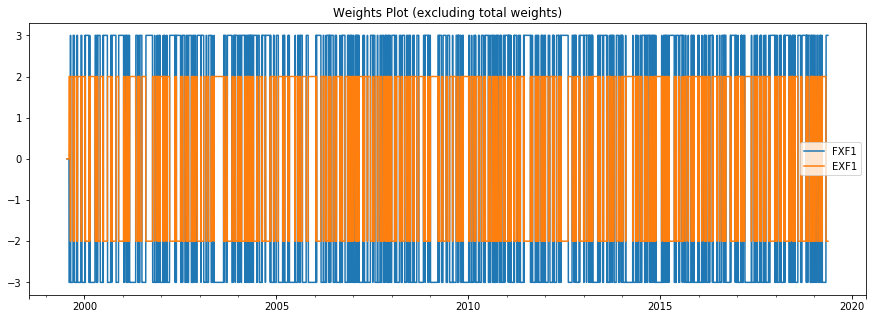

In [13]:
ExF.plot_weights()
plt.title('Weights Plot (including total weights)')

ExF.plot_security_weights()
plt.title('Weights Plot (excluding total weights)')

Text(0.5,1,'DropDown Ratio')

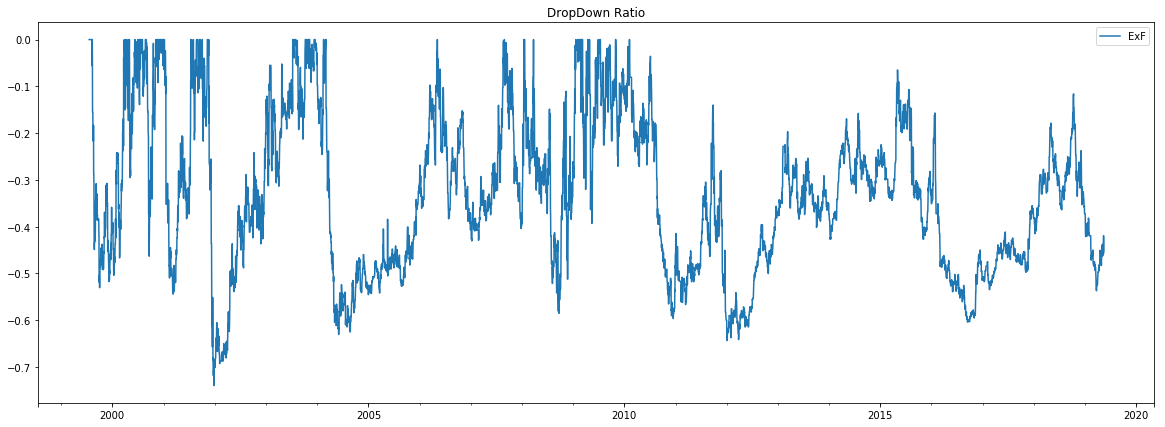

In [14]:
# DropDown Ratio Plot
ExF.prices.to_drawdown_series().plot(figsize=(20, 7))
plt.title('DropDown Ratio')

In [15]:
# list all transactions
ExF.get_transactions().head(8)

price  quantity
Date       Security                   
1999-08-09 EXF1       315.40    6341.0
           FXF1       986.00   -3043.0
1999-08-10 EXF1       332.00    -655.0
           FXF1      1039.00     317.0
1999-08-11 EXF1       332.05     392.0
           FXF1      1015.20    -257.0
1999-08-12 EXF1       334.90    -266.0
           FXF1      1033.00     156.0

## Listing All Result of EnF strategy

In [16]:
with open(sys.path[0] + '/result/EnF-2019-05-24 11:32:54.964336.pkl', 'rb') as f:
    EnF = pickle.load(f)

In [17]:
# Backtest Statistics Table
'''
CAGR: compound annual growth rate
'''
EnF.display()

Stat                 EnF
-------------------  ----------
Start                1999-07-20
End                  2019-05-14
Risk-free rate       0.00%

Total Return         -73.27%
Daily Sharpe         0.16
Daily Sortino        0.25
CAGR                 -6.44%
Max Drawdown         -95.96%
Calmar Ratio         -0.07

MTD                  -0.99%
3m                   14.09%
6m                   1.94%
YTD                  -1.34%
1Y                   -1.98%
3Y (ann.)            22.37%
5Y (ann.)            4.61%
10Y (ann.)           12.67%
Since Incep. (ann.)  -6.44%

Daily Sharpe         0.16
Daily Sortino        0.25
Daily Mean (ann.)    8.09%
Daily Vol (ann.)     50.21%
Daily Skew           -0.03
Daily Kurt           9.77
Best Day             30.75%
Worst Day            -29.67%

Monthly Sharpe       0.17
Monthly Sortino      0.31
Monthly Mean (ann.)  9.38%
Monthly Vol (ann.)   56.59%
Monthly Skew         0.52
Monthly Kurt         2.66
Best Month           63.26%
Worst Month          -58.41%


(10032.01, 18789.99)

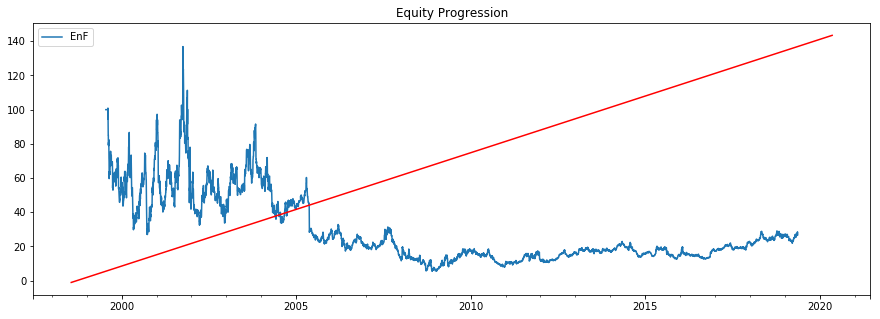

In [18]:
# Equity Plot
EnF.plot()
plt.plot(plt.xlim(), plt.ylim(), 'k-', color = 'r')
plt.ylim(plt.ylim())
plt.xlim(plt.xlim())

In [19]:
# return in each month
list(EnF.values())[0].return_table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
1999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.365874,-0.118126,0.031370,-0.055767,0.017373,-0.445942
2000,0.050198,0.024426,0.010884,-0.393185,0.000729,0.034432,0.610542,0.170169,-0.584101,0.227605,0.580998,0.632615,0.696722
2001,-0.417483,-0.171169,0.054837,0.331049,-0.041419,-0.148125,0.266186,0.426140,0.035455,-0.175978,-0.116012,-0.283192,-0.459572
2002,-0.193000,-0.074894,-0.110321,0.392007,0.167310,0.124294,-0.114563,-0.047511,-0.128177,0.063660,-0.151250,0.059089,-0.146967
2003,0.269912,0.218579,-0.133144,-0.062670,-0.044952,0.070363,0.370115,-0.044820,-0.174581,0.505299,-0.291177,-0.061498,0.390385
2004,-0.051703,0.137084,-0.191978,-0.232997,-0.078214,0.079956,-0.159875,0.148271,0.044695,0.133559,-0.003120,-0.055135,-0.284141
2005,0.073357,0.056584,0.022812,-0.018693,-0.404431,-0.094100,-0.041070,-0.107693,0.107945,-0.124606,0.148275,0.130359,-0.338474
2006,-0.125072,0.153922,-0.040992,-0.221005,-0.196379,0.129639,-0.047574,0.272184,0.075228,-0.020988,-0.175508,-0.048863,-0.315149
2007,-0.016198,-0.048036,0.156529,-0.054598,0.082346,-0.003613,0.124689,0.146591,-0.098111,-0.186171,-0.156144,-0.212487,-0.305378
2008,0.201115,-0.207982,0.135984,-0.092658,-0.080336,-0.107177,-0.111057,0.110691,-0.379875,0.305620,-0.277062,0.009249,-0.530408


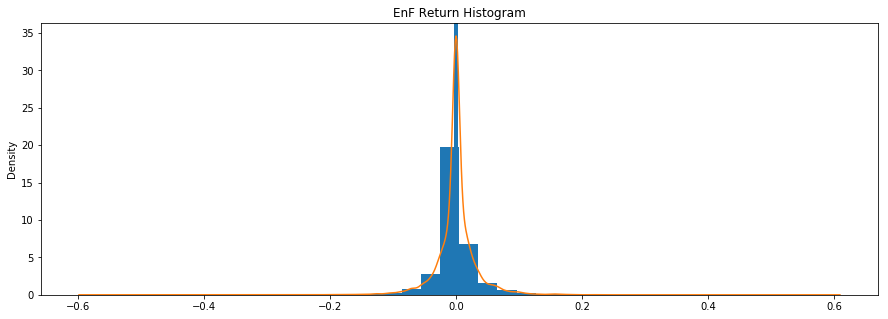

In [20]:
# return histogram
EnF.plot_histogram()

Text(0.5,1,'Weights Plot (excluding total weights)')

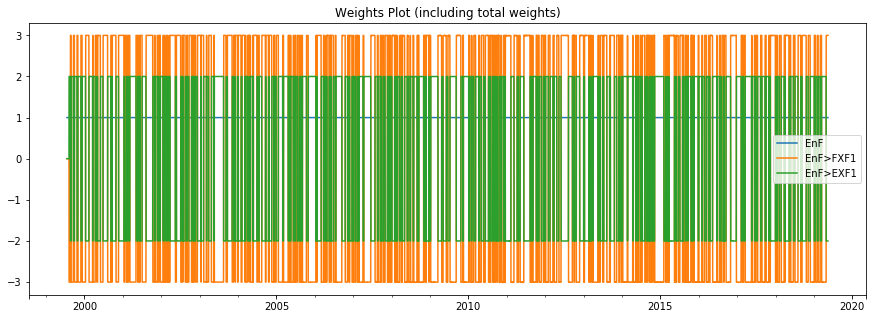

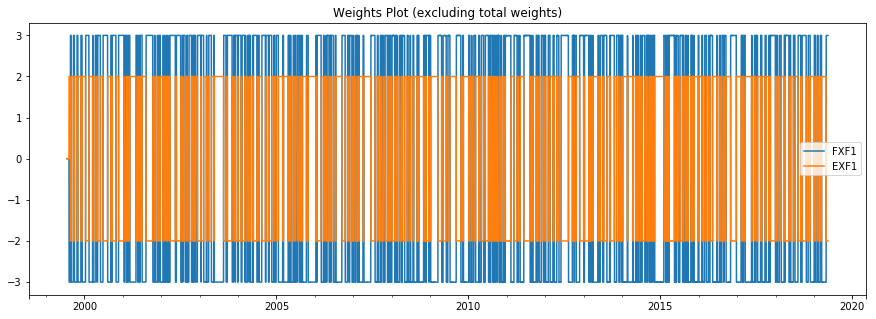

In [21]:
EnF.plot_weights()
plt.title('Weights Plot (including total weights)')

EnF.plot_security_weights()
plt.title('Weights Plot (excluding total weights)')

Text(0.5,1,'DropDown Ratio')

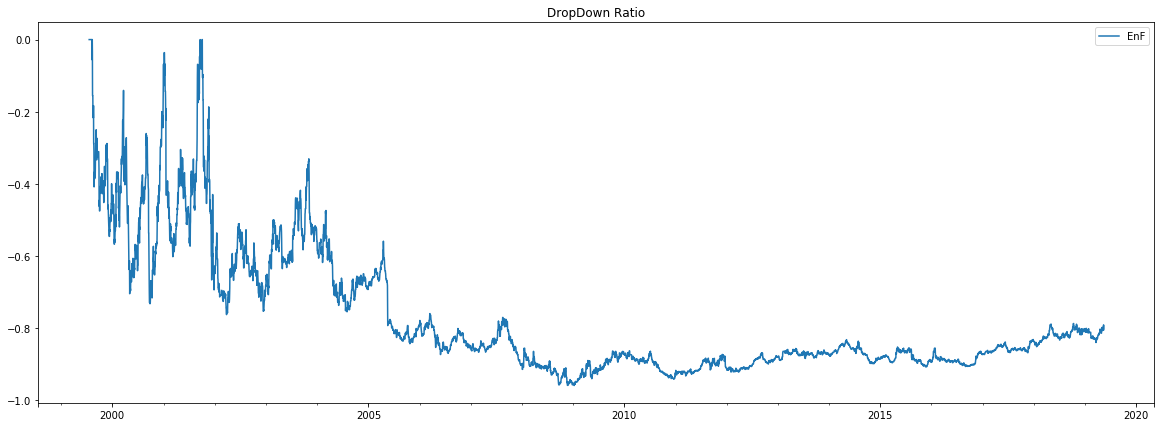

In [22]:
# DropDown Ratio Plot
EnF.prices.to_drawdown_series().plot(figsize=(20, 7))
plt.title('DropDown Ratio')

In [23]:
# list all transactions
EnF.get_transactions().head(8)

price  quantity
Date       Security                   
1999-08-09 EXF1       315.40    6341.0
           FXF1       986.00   -3043.0
1999-08-10 EXF1       332.00    -655.0
           FXF1      1039.00     317.0
1999-08-11 EXF1       332.05     392.0
           FXF1      1015.20    -257.0
1999-08-12 EXF1       334.90    -266.0
           FXF1      1033.00     156.0

## Combine Stratgies

In [24]:
with open(sys.path[0] + '/trade/EnF-2019-05-24 11:32:54.964336.pkl', 'rb') as f:
    Ntrade = pickle.load(f)
with open(sys.path[0] + '/trade/ExF-2019-05-24 11:33:40.619394.pkl', 'rb') as f:
    Xtrade = pickle.load(f)

In [25]:
combine = bt.run(Ntrade, Xtrade)

In [26]:
# Backtest Statistics Table
combine.display()

Stat                 EnF         ExF
-------------------  ----------  ----------
Start                1999-07-20  1999-07-20
End                  2019-05-14  2019-05-14
Risk-free rate       0.00%       0.00%

Total Return         -73.27%     5457.08%
Daily Sharpe         0.16        0.53
Daily Sortino        0.25        0.85
CAGR                 -6.44%      22.48%
Max Drawdown         -95.96%     -73.99%
Calmar Ratio         -0.07       0.30

MTD                  -0.99%      -1.00%
3m                   14.09%      2.90%
6m                   1.94%       -23.01%
YTD                  -1.34%      -13.42%
1Y                   -1.98%      -30.65%
3Y (ann.)            22.37%      4.04%
5Y (ann.)            4.61%       -7.03%
10Y (ann.)           12.67%      0.96%
Since Incep. (ann.)  -6.44%      22.48%

Daily Sharpe         0.16        0.53
Daily Sortino        0.25        0.85
Daily Mean (ann.)    8.09%       26.59%
Daily Vol (ann.)     50.21%      50.19%
Daily Skew           -0.03       0.2

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

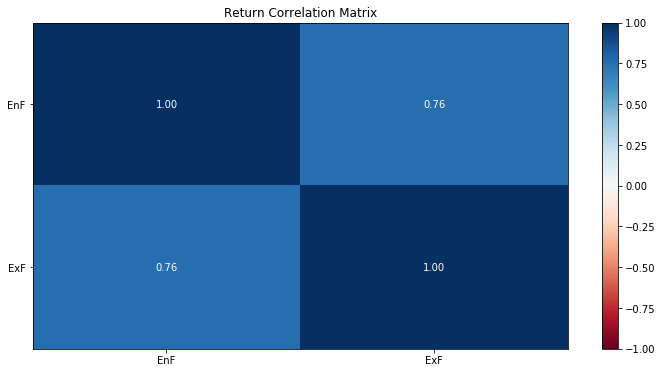

In [27]:
combine.plot_correlation()

In [28]:
# 組合策略
# 根據 1/波動率 給予權重
data = bt.merge(*[v.prices for v in combine.values()])
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

s
0% [############################# ] 100% | ETA: 00:00:01

(10030.904999999999, 18790.095)

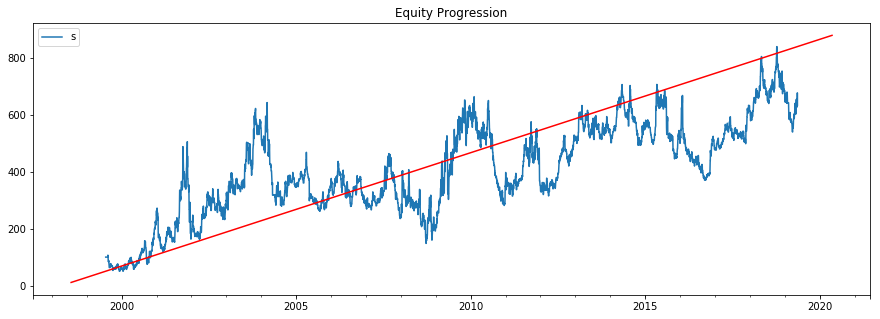

In [29]:
# Equity Plot
res.plot()
plt.plot(plt.xlim(), plt.ylim(), 'k-', color = 'r')
plt.ylim(plt.ylim())
plt.xlim(plt.xlim())

In [30]:
# return in each month
list(res.values())[0].return_table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
1999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.353143,-0.131435,0.031903,0.026780,0.023847,-0.390516
2000,0.119392,-0.045443,0.249691,-0.107653,-0.047577,0.135952,0.610526,0.188062,-0.447656,0.227411,0.580844,0.632486,3.315748
2001,-0.387478,-0.169553,0.048029,0.330934,-0.014845,-0.115204,0.432110,0.439976,0.035429,-0.003263,0.004026,-0.429501,-0.246050
2002,-0.064607,-0.076111,-0.010999,0.391994,0.140394,0.124188,-0.050187,0.017850,-0.121230,0.089143,-0.094545,0.177012,0.504083
2003,0.227137,0.061452,-0.151628,0.084880,-0.044900,0.070358,0.369997,-0.088395,-0.103665,0.505257,-0.118674,0.004942,0.829047
2004,-0.124775,0.216666,-0.264401,-0.256606,-0.081223,0.109917,-0.134811,0.100922,0.076941,0.148526,-0.007954,-0.085547,-0.365333
2005,0.073327,0.056574,-0.010049,0.008313,-0.213365,-0.036865,-0.016647,-0.094545,0.106120,-0.063096,0.148288,0.130389,0.027195
2006,-0.086350,0.153919,0.036939,-0.092817,-0.116298,0.037446,-0.136525,0.223841,0.059767,0.032227,-0.190018,-0.071553,-0.209562
2007,0.000775,-0.047454,0.156423,-0.035204,0.060359,-0.003509,0.075698,0.232548,-0.098074,-0.082733,-0.160450,-0.162940,-0.133707
2008,0.374253,-0.157276,0.146158,-0.082304,-0.061626,-0.104039,-0.142222,0.058974,-0.231179,0.305065,-0.138774,0.076698,-0.134458


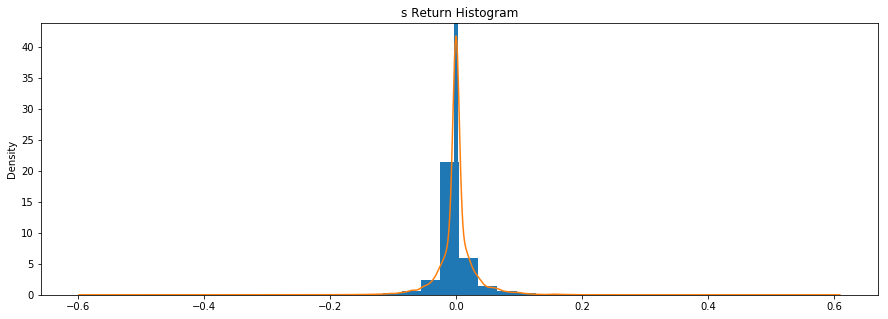

In [31]:
# return histogram
res.plot_histogram()

Text(0.5,1,'Weights Plot (excluding total weights)')

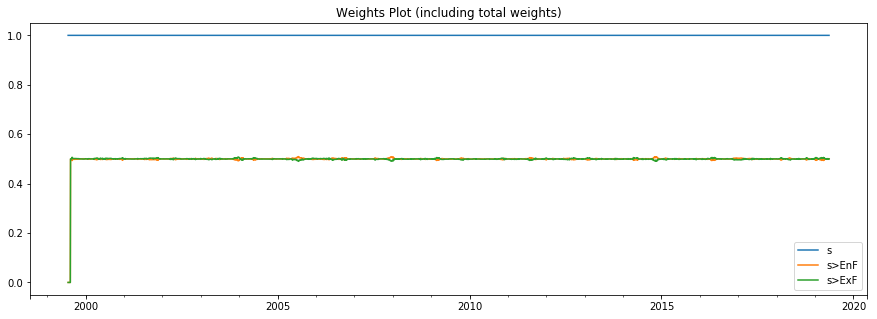

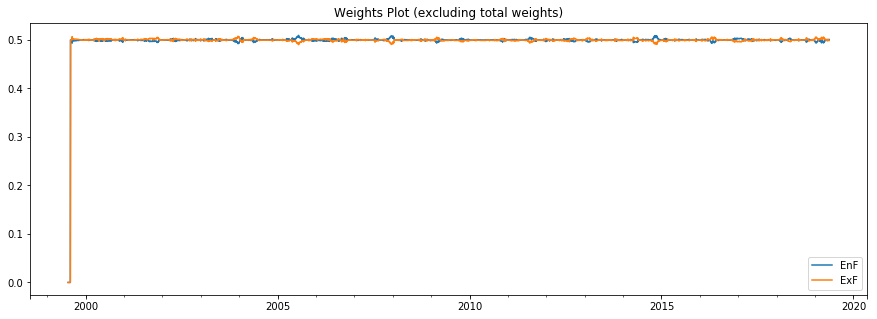

In [32]:
res.plot_weights()
plt.title('Weights Plot (including total weights)')

res.plot_security_weights()
plt.title('Weights Plot (excluding total weights)')

Text(0.5,1,'DropDown Ratio')

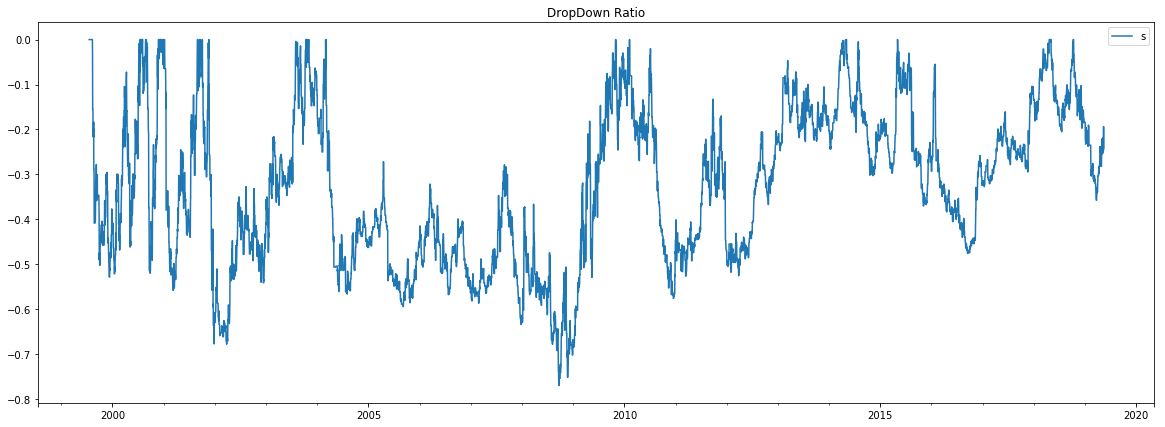

In [33]:
# DropDown Ratio Plot
res.prices.to_drawdown_series().plot(figsize=(20, 7))
plt.title('DropDown Ratio')

In [34]:
# list all transactions
res.get_transactions().head(8)

price  quantity
Date       Security                    
1999-08-10 EnF       94.39816    5296.0
           ExF       94.39816    5296.0
1999-08-24 EnF       59.67149       1.0
           ExF       59.67149       1.0
1999-08-25 EnF       63.03709    -340.0
           ExF       56.29997     380.0
1999-08-26 EnF       63.82801     -72.0
           ExF       55.59425      83.0